In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

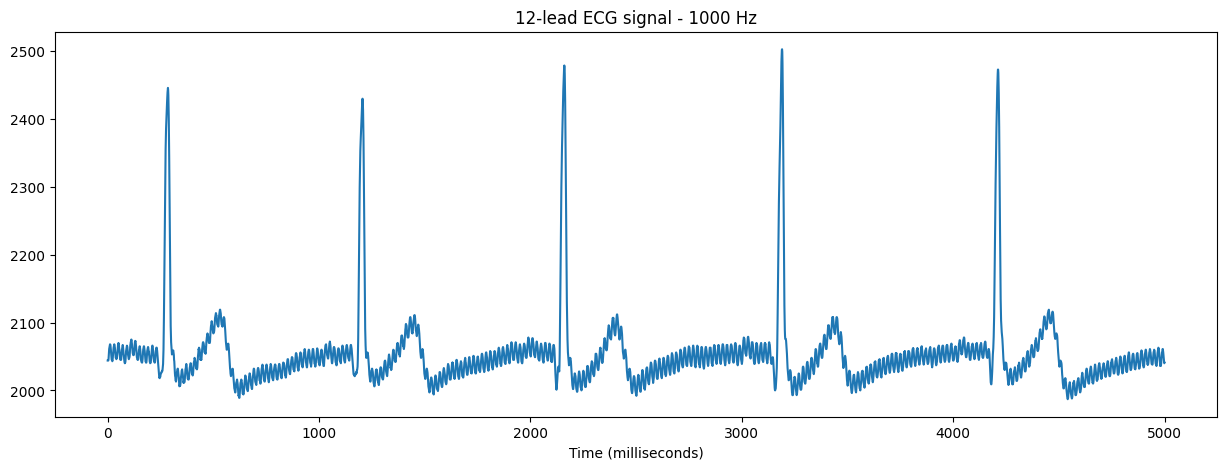

In [88]:
path = r'./ecg.csv'  ##12-leads
df = pd.read_csv(path)
df.rename(columns={'2044.0':'Frequency'}, inplace= True)
#ecg_df = pd.DataFrame(df[3:-1])
#print(type(ecg_df))
#print(type(pd.DataFrame(ecg_df.values)))
#df_arr = df[3:-1].to_numpy()
#type(df_arr)
#df_ls = df_arr.tolist()
plt.figure(figsize=(15,5))
plt.title("12-lead ECG signal - 1000 Hz")
plt.plot(df[0:5000])
plt.xlabel('Time (milliseconds)')
plt.show()

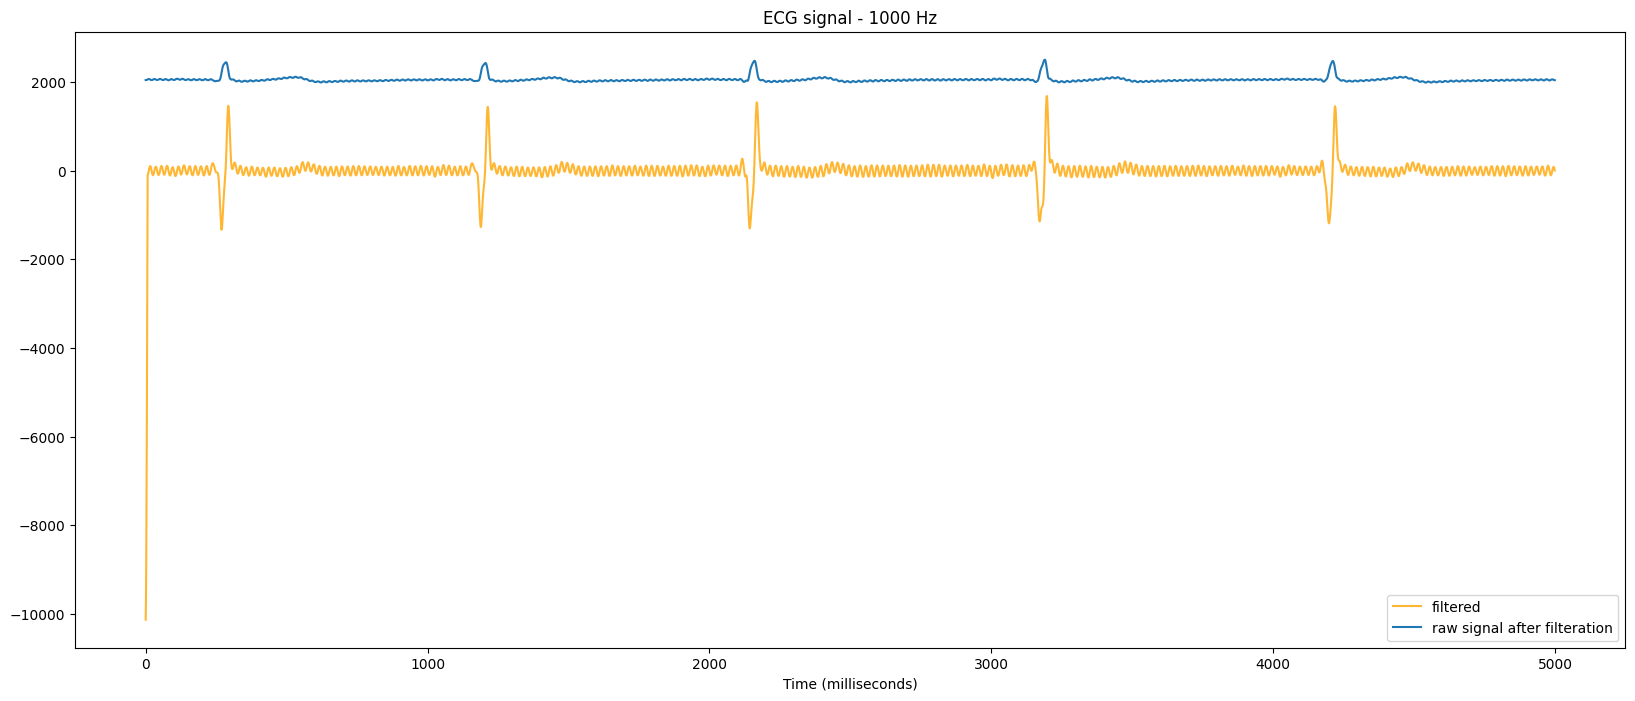

In [146]:
# linear spaced vector between 0.5 pi and 1.5 pi 
v = np.linspace(0.5 * np.pi, 1.5 * np.pi, 15)

# create sine filter for approximating QRS feature
peak_filter = np.sin(v)
'''plt.figure(figsize=(5,5))
plt.plot(peak_filter)
plt.show()'''

# compute cross correlation between ecg and the sine filter
ecg_transformed = np.correlate(df["Frequency"], peak_filter, mode="same")
# and plot the raw + filtered signal
plt.figure(figsize=(20,8))
plt.title('ECG signal - 1000 Hz')
plt.plot(ecg_transformed[0:5000], alpha = 0.8, c='orange')
plt.plot(df[0:5000], alpha = 1)
plt.gca().legend(('filtered','raw signal after filteration'))
plt.xlabel('Time (milliseconds)')
plt.show()

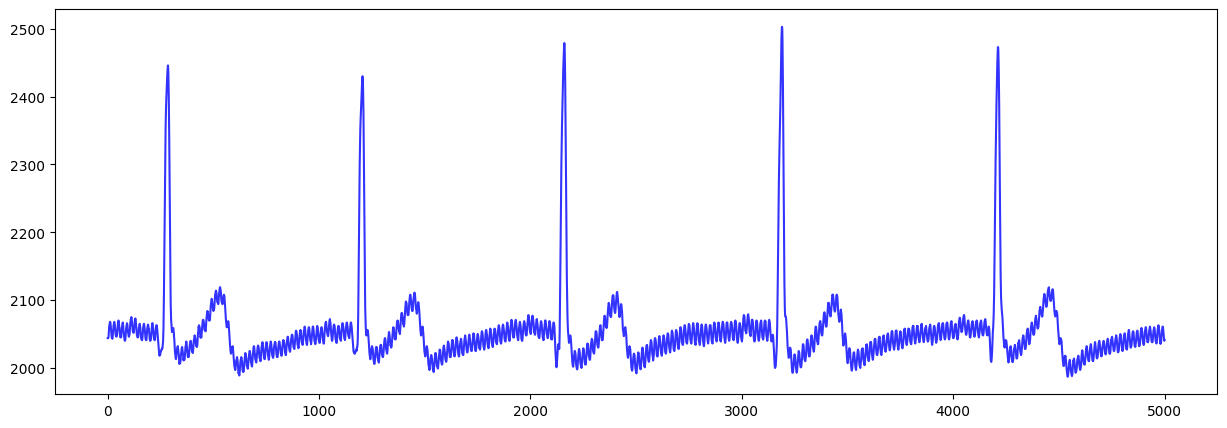

In [152]:
plt.figure(figsize=(15,5))
#plt.plot(ecg_transformed[0:5000], alpha = 0.8, c='orange')
plt.plot(df[0:5000], alpha = 0.8, c='blue')
plt.show()

In [168]:
#from scipy.datasets import electrocardiogram
from scipy.signal import find_peaks
from scipy import interpolate
from scipy import stats
import signal
from scipy import signal

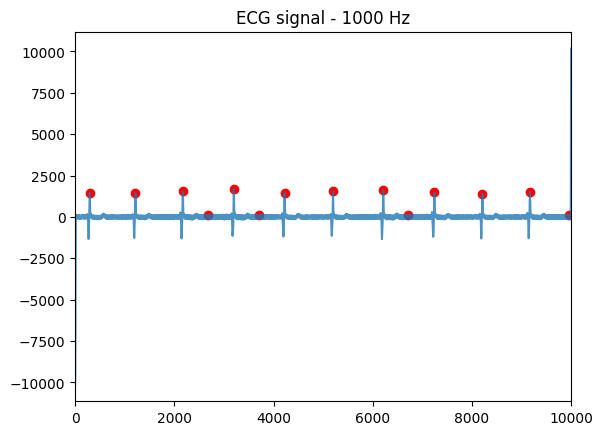

In [161]:
# calculates the differences between consecutive samples
diff_sig_ecg = np.diff(df)
rr_peaks, _ = find_peaks(ecg_transformed, distance=1000*(30/60))
plt.plot(ecg_transformed, alpha = 0.8)
plt.scatter(rr_peaks, ecg_transformed[rr_peaks], color='red')
plt.xlim(0,10000)
plt.title("ECG signal - 1000 Hz")
plt.show()

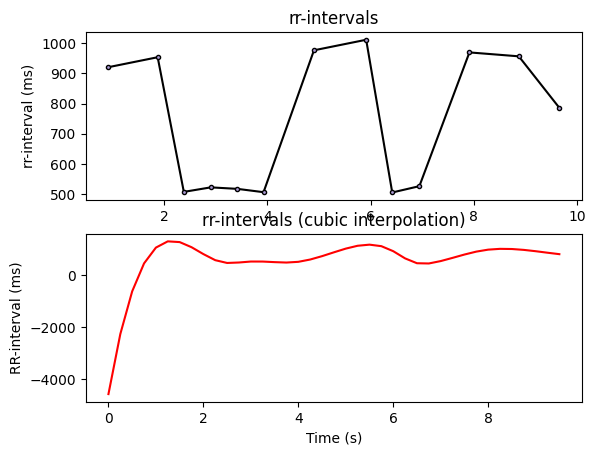

In [170]:
# compute the diff along the time axis to end up with the R-R intervals
rr_ecg = np.diff(rr_peaks)

# fit function to the dataset
x_ecg = np.cumsum(rr_ecg)/1000 
f_ecg = interpolate.interp1d(x_ecg, rr_ecg, kind='cubic', fill_value= 'extrapolate')

# sample rate for interpolation
fs = 4
steps = 1 / fs

# sample using the interpolation function
xx_ecg = np.arange(0, np.max(x_ecg), steps)
rr_interpolated_ecg = f_ecg(xx_ecg)

plt.subplot(211)
plt.title('rr-intervals')
plt.plot(x_ecg, rr_ecg, color='k', markerfacecolor='#A999D1',marker='o', markersize=3)
plt.ylabel('rr-interval (ms)')

plt.subplot(212)
plt.title('rr-intervals (cubic interpolation)')
plt.plot(xx_ecg, rr_interpolated_ecg, color='r')
plt.xlabel('Time (s)')
plt.ylabel('RR-interval (ms)')

plt.show()

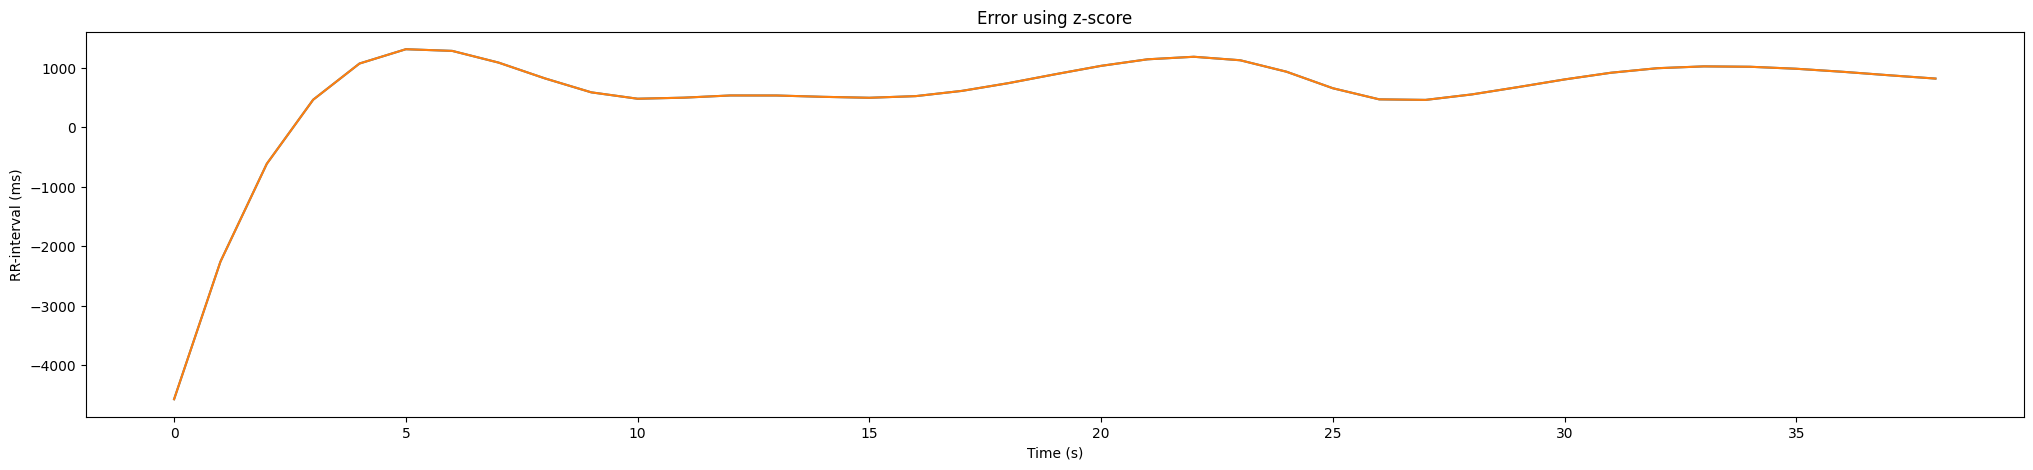

In [171]:
rr_ecg[np.abs(stats.zscore(rr_ecg)) > 2] = np.median(rr_ecg)

x_ecg = np.cumsum(rr_ecg)/1000
f_ecg = interpolate.interp1d(x_ecg, rr_ecg, kind='cubic', fill_value= 'extrapolate')

xx_ecg = np.arange(0, np.max(x_ecg), steps)
clean_rr_interpolated_ecg = f_ecg(xx_ecg)

plt.figure(figsize=(25,5))
plt.title('Error using z-score')
plt.plot(rr_interpolated_ecg)
plt.plot(clean_rr_interpolated_ecg)
plt.xlabel('Time (s)')
plt.ylabel('RR-interval (ms)')
plt.show()

In [172]:
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    # HRV metrics
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NN50'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNN50 (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

timedomain(rr_ecg)

{'Mean RR (ms)': 743.0769230769231,
 'STD RR/SDNN (ms)': 218.03509298997704,
 "Mean HR (Kubios' style) (beats/min)": 80.74534161490683,
 'Mean HR (beats/min)': 88.4942645393931,
 'STD HR (beats/min)': 26.512865513912693,
 'Min HR (beats/min)': 59.28853754940712,
 'Max HR (beats/min)': 118.81188118811882,
 'RMSSD (ms)': 275.13193804670027,
 'NN50': 5,
 'pNN50 (%)': 38.46153846153846}

e:\Downloads\ANACONDA3\envs\base2\lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 39, using nperseg = 39
  warnings.warn('nperseg = {0:d} is greater than input length '


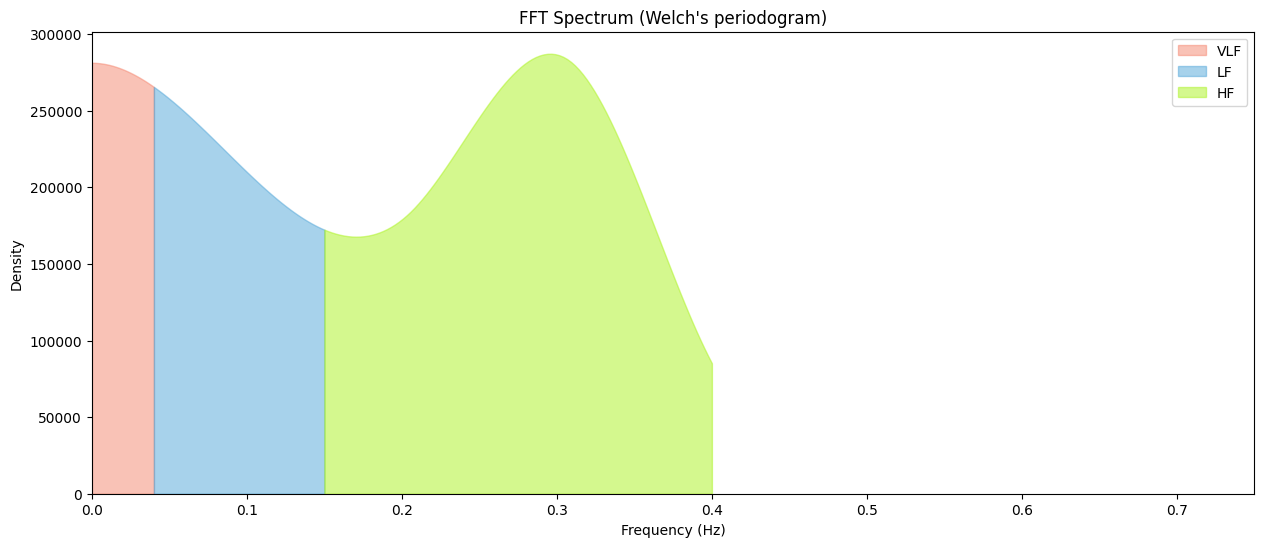

In [173]:
fxx, pxx = signal.welch(x=clean_rr_interpolated_ecg, fs=fs, nperseg=256)

# fit a function for plotting bands
powerspectrum_f = interpolate.interp1d(fxx, pxx, kind='cubic', fill_value= 'extrapolate')

plt.figure(figsize=(15,6))
plt.title("FFT Spectrum (Welch's periodogram)")

# setup frequency bands for plotting
x_VLF = np.linspace(0, 0.04, 100)
x_LF = np.linspace(0.04, 0.15, 100)
x_HF = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_VLF, powerspectrum_f(x_VLF), alpha=0.5, color="#F5866F", label="VLF")
plt.gca().fill_between(x_LF, powerspectrum_f(x_LF), alpha=0.5, color="#51A6D8", label="LF")
plt.gca().fill_between(x_HF, powerspectrum_f(x_HF), alpha=0.5, color="#ABF31F", label="HF")

plt.gca().set_xlim(0, 0.75)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")

plt.legend()
plt.show()